In [14]:
import numpy as np
import matplotlib.pyplot as plt
import yasa
import pandas as pd
import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch
from sklearn.metrics import accuracy_score

### データの用意

In [15]:
[alice_files] = fetch_data(subjects=[0], recording=[1])
print(alice_files)

edf = mne.io.read_raw_edf(alice_files[0], stim_channel='Event marker',
                                misc=['Temp rectal'])
annot = mne.read_annotations(alice_files[1])

edf.set_annotations(annot, emit_warning=False)

annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

events, _ = mne.events_from_annotations(
    edf, event_id=annotation_desc_2_event_id, chunk_duration=30.)

tmax = 30. - 1. / edf.info['sfreq']

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

epochs_test = mne.Epochs(raw=edf, events=events, event_id=event_id,
                         tmin=0., tmax=tmax, baseline=None)

hypno = epochs_test.events[:, 2] - 1

Using default location ~/mne_data for PHYSIONET_SLEEP...
['/net/nfs/home/imamura22/mne_data/physionet-sleep-data/SC4001E0-PSG.edf', '/net/nfs/home/imamura22/mne_data/physionet-sleep-data/SC4001EC-Hypnogram.edf']
Extracting EDF parameters from /net/nfs/home/imamura22/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
2650 matching events found
No baseline correction applied
0 projection items activated


In [16]:
sls = yasa.SleepStaging(edf, eeg_name="EEG Fpz-Cz")
hypno_pred = sls.predict()
hypno_pred = yasa.hypno_str_to_int(hypno_pred)

csv_pre = pd.DataFrame(hypno_pred)
csv_pre.to_csv("./csv_pre.csv")

### 状態遷移の修正

- W→N2, W→N3の状態遷移を取り除く
- W→N2→N3 を W→N1→N2→N3とする

パターン判別用関数

In [17]:
# Pattern 1: 0, x, x, ... x, x, 0 (1 < x < 4)
# Pattern 2: 0, 2, 2, 3, ...
def check_trans(array, index, current, count):
    stage = array[index + 1]
    
    # 0, 2, 2, ... 2, 0
    if stage == 0:
        return ["Pattern 1", count]

    elif stage != 0 and stage != current:
        # 0, 2, 2, 3, ... 
        if current == 2 and stage == 3:
            return ["Pattern 2", 0]

        return ["NIL", 0]

    # 同じステージだったら、調査位置とカウントを1増やして再帰
    elif stage == current:
        return check_trans(array, index + 1, current, count + 1)

修正用関数

In [22]:
def fix_hypno(array):
    size = array.shape[0]
    res = [False, 0]

    for i in range(size - 1):
        # パターン調査
        if array[i] == 0:
            for j in [2,3]:
                # 0, 0, j, ... の並び
                if array[i + 1] == j:
                    count = 0
                    res = check_trans(array, i, j, count)

        # 修正
        # Pattern 1: 指定範囲を全て0に置換
        if res[0] == "Pattern 1" and res[1] != 0:
            array[i + 1] = 0
            res[1] -= 1
            if res[1] == 0:
                res[0] = "NIL"
        
        # Pattern 2: Pattern 2が始まる直前の0を1に置換
        if res[0] == "Pattern 2":
            array[i] = 1
            res[0] = "NIL"

In [23]:
# hypno_pred = np.array([0,0,0,2,2,0,0,2,3,0])\

fixed = np.copy(hypno_pred)

fix_hypno(fixed)

csv_fixed = pd.DataFrame(fixed)
csv_fixed.to_csv("./csv_fixed_2.csv")

### ヒプノグラムの表示

<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

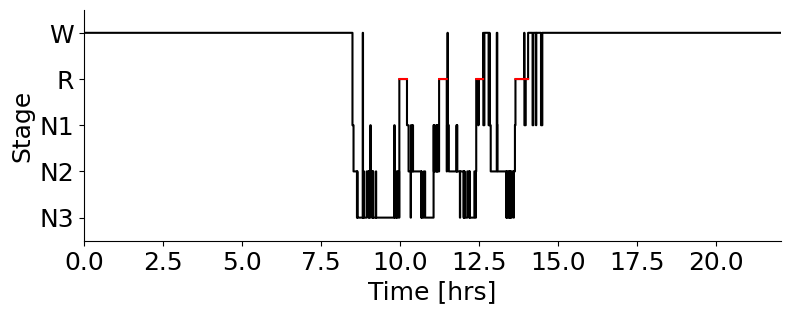

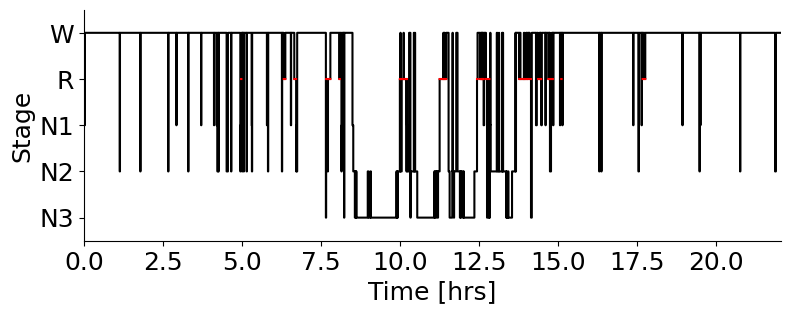

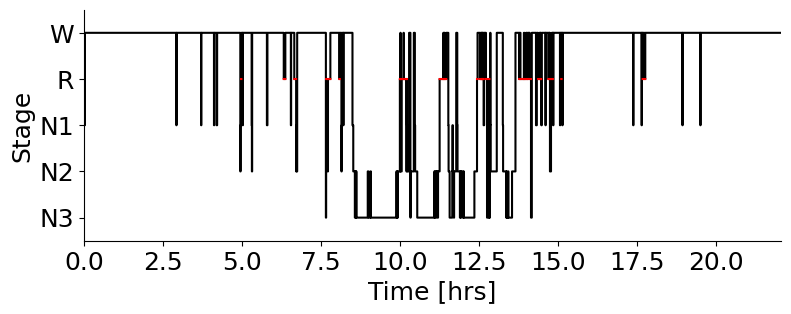

In [24]:
yasa.plot_hypnogram(hypno)
yasa.plot_hypnogram(hypno_pred)
#yasa.plot_hypnogram(fix_case1)
yasa.plot_hypnogram(fixed) 
#yasa.plot_hypnogram(fix_case3)

In [25]:
acc_bef = accuracy_score(hypno, hypno_pred) # 修正前の正解率
#acc_case1 = accuracy_score(hypno, fix_case1)
acc_aft = accuracy_score(hypno, fixed) # 修正後の正解率
#acc_case3 = accuracy_score(hypno, fix_case3)

print('正解率')
print('  修正前', acc_bef)
#print('  修正後(方法1)', acc_case1)
print('  修正後', acc_aft) 
#print('  修正後(方法3)', acc_case3)

正解率
  修正前 0.870188679245283
  修正後 0.8732075471698113
